In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In this short notebook, I build a classifier to determine whether an image is a beetle or The Beatles!

## Step 1: Download images of beetles and The Beatles

Using the python package [ddg_search](https://pypi.org/project/duckduckgo-search/) we begin by searching for images of beetles and The Beatles.

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
from fastdownload import download_url
from fastai.vision.all import *

download_url(search_images('beetles', max_images=1)[0], 'beetle.jpg', show_progress=False)
#Image.open('beetle.jpg').to_thumb(256,256)

Searching for 'beetles'


Path('beetle.jpg')

In [4]:
download_url(search_images('the Beatles', max_images=1)[0], 'the_beatles.jpg', show_progress=False)
#Image.open('the_beatles.jpg').to_thumb(256,256)

Searching for 'the Beatles'


Path('the_beatles.jpg')

We now save searches for beetles and The Beetles into folders.

In [5]:
searches = 'beetles','the Beatles'
path = Path('beetle_or_the_Beatles')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'beetles'
Searching for 'the Beatles'


## Step 2: Train a model

We remove photos which didn't download correctly.

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

We use a 'Datablock' to separate the data into training and validation sets.

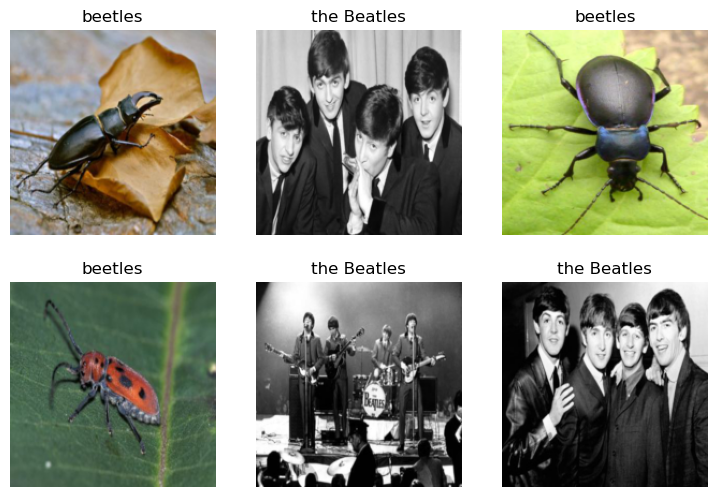

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

We now use 'resnet18' to train our model, and the 'fine_tune()' method from 'fastai' to tune the model.

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.623580,4.855602,0.545455,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.892229,3.018108,0.545455,00:04
1,0.693663,0.710887,0.272727,00:04
2,0.487951,0.266973,0.090909,00:04


## Step 3: Test the model

We can now test our model on the images of a beetle and of the Beatles we downloaded in Step 1.

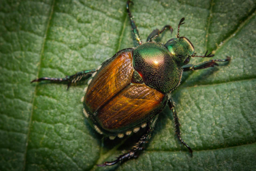

In [9]:
Image.open('beetle.jpg').to_thumb(256,256)

In [10]:
is_beetle,_,probs = learn.predict('beetle.jpg')
print(f"This is a: {is_beetle}.")
print(f"Probability it's a beetle: {probs[0]:.4f}")

This is a: beetles.
Probability it's a beetle: 1.0000


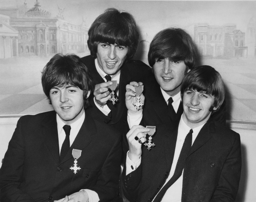

In [11]:
Image.open('the_beatles.jpg').to_thumb(256,256)

In [12]:
is_the_beatles,_,probs = learn.predict('the_beatles.jpg')
print(f"This is a: {is_the_beatles}.")
print(f"Probability it's the Beatles: {probs[1]:.4f}")

This is a: the Beatles.
Probability it's the Beatles: 0.9777
